### Locality-Sensitive Hashing - LSH
Here we implement LSH for point distributions in the 2D space to explore the concept. The method is very powerful for large datasets and high dimentional data.
We'll implement:
- a hash class with methods to retrieve nearest neighbors
- observe the hash extent on a cluster dataset and a uniform dataset
- 

#### Build the ensembles

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [5]:
from torch.distributions import MultivariateNormal

In [6]:
n_centers = 5
n_pts = 300
centers = torch.rand(n_centers, 2)*60-30
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-21.057,  -0.807],
         [ 29.140, -19.896],
         [  5.037,  11.616],
         [  4.985, -22.294],
         [  4.327,  25.490]]))

In [7]:
g = MultivariateNormal(centers[0], torch.diag(tensor([5.,5.])))

In [8]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [9]:
data_l = [generate_points(c,5.) for c in centers]
data = torch.cat(data_l)

In [10]:
data.shape

torch.Size([1500, 2])

In [11]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1, alpha=0.5)
        plt.plot(*c, marker='x', markersize=7, color='k', mew=5)
        plt.plot(*c, marker='x', markersize=3, color='orange', mew=1)

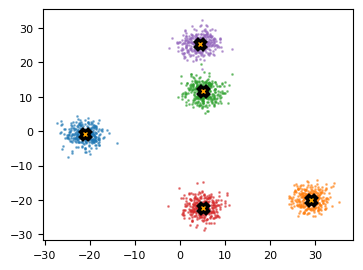

In [12]:
plot_data(centers, data_l)

In [13]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]

#### LSH

The algorithm consists of separating the space with random lines (or planes in dimensions larger than 2) and defining the position of each point of the data as the projections of the point's coordinates on each hash direction. The idea is to project each point on a new discretized vector space, each point vector is projected on each of the k-hash vectors and the floor is then taken to get the discretiation of space (flooring the result is what forms the hash lines perpendicular to the hash vector and defines the discretely spaced by 1 values along the hash vector). A bias term $c\in \left[0, 1\right)$ is added in order to force the discret areas to not all occur at the same distance of the origin and so add more randomness to the hashing process. 
The points will hence be distributed in buckets, that is, closed areas of the 2D space delimited by the hash lines intersections. <br>
>We can define `k` hash functions of the form $h_{i}(x_{j}) = \lfloor a_{i}x_{i} + b_{i}y_{j} + c_{i} \rfloor$, that is $h_{i}(x_{j}) = \bigl\lfloor \left[a_{i},b_{i}\right] \cdot \left[\begin{smallmatrix}x_{j}\cr y_{j}\end{smallmatrix}\right] + c_{i} \bigr\rfloor$ or in vectorial form: <br> 
$H(\boldsymbol{X})  = \lfloor \boldsymbol{A} \boldsymbol{X} + \boldsymbol{c} \rfloor$, <br> 
with the matrix of the $k$ projection vectors $\boldsymbol{A} = \left[\begin{smallmatrix}a_{0}, b_{0}\\ \vdots \\ a_{k}, b_{k}\end{smallmatrix}\right]$, 
the data points $\boldsymbol{X} = \left[\begin{smallmatrix}x_{0}, y_{0}\\ \vdots \\ x_{n}, y_{n}\end{smallmatrix}\right] $ and the biases
$\boldsymbol{c} = \left[\begin{smallmatrix}c_{0}\\ \vdots \\ c_{k}\end{smallmatrix}\right]$.

We can use Pytorch tensor calculation to accelerate the process.

To perform the hashing, each point $x_{i}$ of the data will be transformed by each $f_{i}(x_{j}) = a_{i}x_{j} + b_{i}$ and then floored to the previous integer value to discretise space and build the 'buckets'.

> Let's build the hash matrix of $\boldsymbol{a}_{i}$'s and the bias vector of $c_{i}$'s:

For the $\boldsymbol{a}_{i}$'s we could use a uniform random variable sampled from $[-0.5,0.5)^2$ for $a_{i}, b_{i}$ and it will work but there will be an $y=\pm x$ bias, which will translate in the nearest neighbors search.
>A normal value for `k` could be `50` but in the following examples we'll x10 the number of hashes to visualize the sampling uniformity.

In [75]:
k_hashes = 50
dim = X.shape[1]
H_matrix = torch.rand((dim, k_hashes*10))-0.5

(-1.2, 1.2)

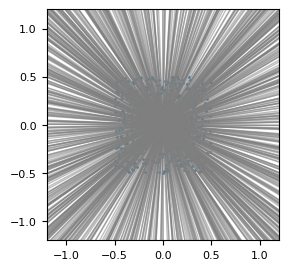

In [76]:
fig, ax = plt.subplots(figsize=(3,3))
xs = torch.linspace(-1.5,1.5,10)
ax.scatter(*H_matrix, s=1)
for a,b in H_matrix.transpose(0,1):
    def f(x): return -a*x/b
    ax.plot(xs, f(xs), linewidth=1, alpha=0.5, color='C7')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

The difference is clear when compared to a real circular uniform distribution sampled from $[0,2\pi)$ as seen below, with $a_{i}=\cos\theta$ and $b_{i}=\sin\theta$ 

In [77]:
H_theta = 2*torch.pi*torch.rand(k_hashes*10)
H_xs = torch.cos(H_theta)
H_ys = -torch.sin(H_theta) #sign is not important nor needed here, just to keep the look of a rotation matrix 

H_matrix = torch.stack([H_xs, H_ys])
H_slope = H_ys/H_xs
H_bias = torch.rand(k_hashes)

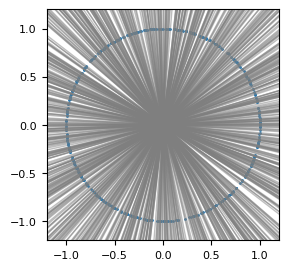

In [78]:
fig, ax = plt.subplots(figsize=(3,3))
xs = torch.linspace(-1.5,1.5,10)
ax.scatter(*H_matrix, s=1)
for a in H_slope: 
    ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2);

Now again with the uniform sampling above but with `k=50` hashes:

In [79]:
H_theta = 2*torch.pi*torch.rand(k_hashes)
H_xs = torch.cos(H_theta)
H_ys = -torch.sin(H_theta) #sign is not important nor needed here, just to keep the look of a rotation matrix 

H_matrix = torch.stack([H_xs, H_ys])
H_slope = H_ys/H_xs
H_bias = torch.rand(k_hashes)

In [80]:
H_matrix.shape

torch.Size([2, 50])

In [81]:
X[0].shape, (X[0] @ H_matrix).shape

(torch.Size([2]), torch.Size([50]))

We can also add a factor `s` to magnify or shrink the hash line spacings.

In [82]:
def h(x, s=1): return (x @ H_matrix * s + H_bias).floor()

In [83]:
hashed = h(X)

For a random point `x` of the data...

In [84]:
x = X[torch.randint(X.shape[0], (1,)).item()]

...we can calculate its likely nearest neighbors by counting the number of edges shared between the points:

In [85]:
n_matches = 11

In [86]:
v_collide = (h(x) == hashed).sum(dim=1)
nns = torch.where(v_collide > n_matches)[0]

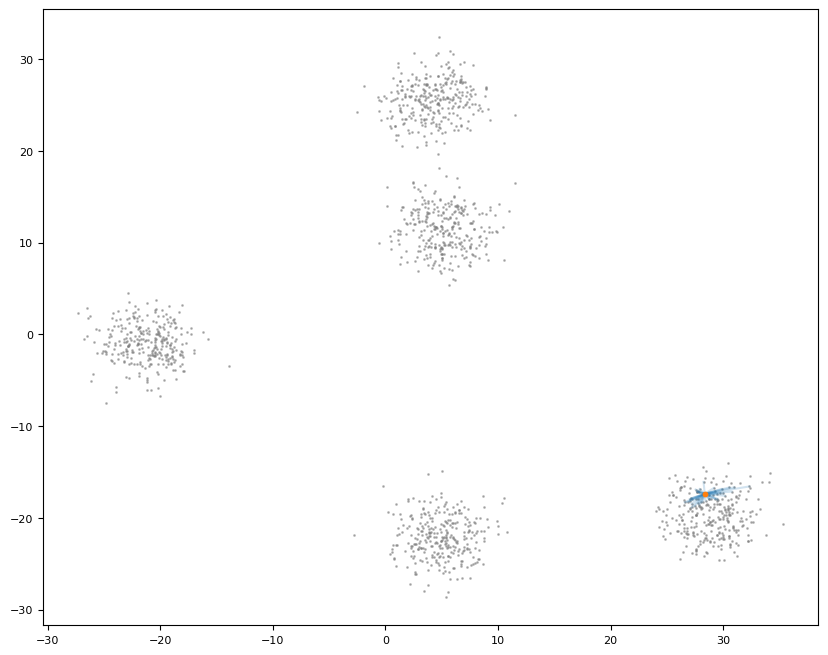

In [87]:
fig, ax = plt.subplots(figsize=(10,8))
for k in X[nns]:
    ax.plot(*torch.stack([x, k]).transpose(0,1), alpha=0.2, color="C0")
ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
ax.scatter(*x.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)

Let's rewrite the hashing operation in a cleaner manner:

In [27]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = torch.pi*torch.rand(n_hash)
        self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide >= n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-5,6):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))/self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.3, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [28]:
X_hash = Data_hash(X,X.shape[1],n_hash=20, scale_factor=0.1)
X_hash.hashed.shape

torch.Size([1500, 20])

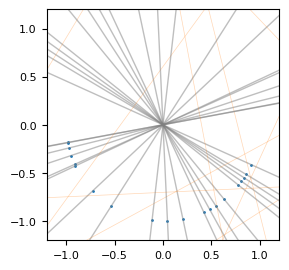

In [29]:
X_hash.plot_hd()

In [30]:
# x = X[torch.randint(X.shape[0],(1,))][0]

In [31]:
_, ref_nns = X_hash.find_nns(x,16)

In [32]:
ref_nns.shape

torch.Size([220])

In [33]:
def plot_nns(pt, nns, X, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2, color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
#     ax.set_xlim(-400, -180)
#     ax.set_ylim(-210, -30);

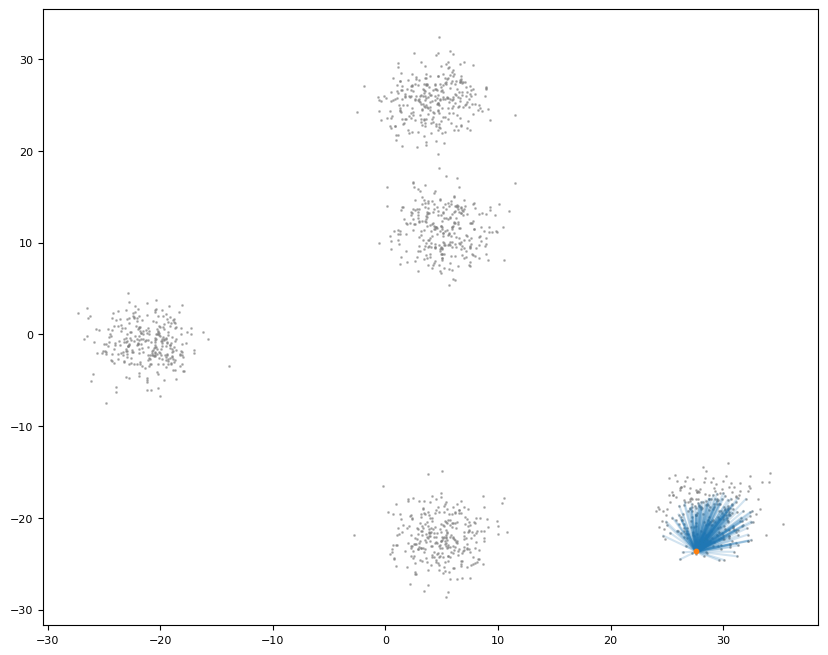

In [34]:
plot_nns(x, ref_nns, X)

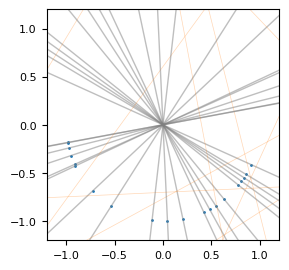

In [35]:
X_hash.plot_hd()

To visualize the effect of the parameter `n_matches`, we can build an animation of the nns changing as `n_matches` increases from 0 -> `n_hash`:

In [36]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [90]:
def one_step(d):
    _, ref_nns = X_hash.find_nns(x,0)
    if d:  
        _, ref_nns = X_hash.find_nns(x,d)
    ax.clear()
    plot_nns(x, ref_nns, X, ax=ax)

In [93]:
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, one_step, frames=X_hash.n_h+1, interval=150, repeat=False)
plt.close()
HTML(ani.to_jshtml())

For `n_hash = 20` and `scale_factor=0.7` we can select a number of collision around 9-10. It seems that 9 gives a good enough cloud of points around the selected point.<br>
For `n_hash = 20` and `scale_factor=0.08`, `n_matches=18` is better because the hash mesh is larger.

#### Vizualization of the NN extension and accelerating the search process

To vizualize more clearly the NN zone, we can repeat the hashing process on a uniformly distributed point ensemble.<br>
We'll also try to hash the hashed data to go from 20 hash functions down to 1 and use the subspaces to narrow down the search space.

> In the previous version of the Data_hash class, we drew the hash directions from a uniform random variable over $[0,2\pi]$ and built the cartesian coordinates from this angle. 
We did this to probabilistically have a rather homogeneous separation of the space with no preferred direction but a simple draw from $[-0.5,0.5]^2$ would work as well. Since we plan to hash the hashed data, we can modify the hash method to account for various dimension of the input data:

> We can also store the hashed buckets for later use and really use the quick lookup time. We can use a python dict (hash table) to store the keys and nns index lists. A torch tensor is not a proper key because two identical tensors in value are different objects: 

In [39]:
hash(tensor(0)), hash(tensor(0))

(140128930225568, 140128903181344)

In [40]:
di = {}
di[tensor(0)] = 1
di[tensor(0)] = 1
di

{tensor(0): 1, tensor(0): 1}

>We can use tuples:

In [41]:
hash(tuple(tensor([1,2]).tolist())), hash(tuple(tensor([1,2]).tolist()))

(-3550055125485641917, -3550055125485641917)

In [42]:
di = {}
di[tuple(tensor([1,2]).tolist())] = 1
di[tuple(tensor([1,2]).tolist())] = 1
di

{(1, 2): 1}

>We can use the exact buckets defined by points that share exactly the same hash vector :`idx = torch.where((t == X_uh.hashed).sum(1)==n_hash)[0]` <br>
Or modified buckets that catch surrounding regions with `idx = torch.where((t == X_uh.hashed).sum(1)>k)[0]` with `k < n_hash`

In [45]:
X_uni = (torch.rand((100000,2))-0.5)*5000

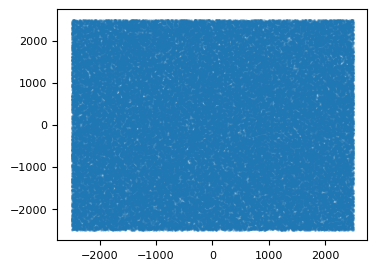

In [46]:
plt.scatter(*X_uni.transpose(0,1), s=1, alpha=0.3)

In [58]:
%%time
di = {}
X_uh = Data_hash(X_uni,X_uni.shape[1], n_hash=20, scale_factor=0.005)
for t in X_uh.hashed[:10000]:
    k = tuple(t.tolist())
    if k in di.keys(): continue
    idx = torch.where((t == X_uh.hashed).sum(1)>=17)[0]
    di[k]=idx.tolist()

CPU times: user 1min 29s, sys: 1.12 s, total: 1min 30s
Wall time: 22.6 s


In [73]:
len(di), X_uni[:10000].shape[0]

(8060, 10000)

In [59]:
nns_d = di[tuple(X_uh.hashed[0].tolist())]
nns_c = torch.where((X_uh.hashed[0] == X_uh.hashed).sum(1) >= 17)[0]
tensor(nns_d) == nns_c

tensor([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True])

It is a long process, 22.5 sec fot only 10k points. (There should be ways to accelerate this.) <br>
Now let's see the performance gain when we want to access the nns:

In [72]:
%%timeit -n 30
nns = di[tuple(X_uh.hashed[0].tolist())]

The slowest run took 24.71 times longer than the fastest. This could mean that an intermediate result is being cached.
10.1 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [71]:
%%timeit -n 30
v_c = (X_uh.hashed[0] == X_uh.hashed).sum(1)
nns = torch.where(v_c >= 17)[0]

2.94 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


>Let's incorporte this method in the class, as well as various input dimensions for the hashing matrix:

In [157]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1, store_hash=False, n_matches=None): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        if dim == 2: self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        else: self.h_mat = torch.rand((dim, n_hash))-0.5
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        self.stored = False
        if store_hash:
            self.hash_dict = {}
            if n_matches: 
                self._store(n_matches)
                self._n_matches = n_matches
            else: 
                self._store(n_hash)
                self._n_matches = n_hash
            self.stored=True
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def _store(self, n_matches):
        for t in self.hashed:
            if tuple(t.tolist()) in self.hash_dict.keys(): continue
            k = tuple(t.tolist())
            idx = torch.where((t == self.hashed).sum(1)>n_matches)[0]
            self.hash_dict[k]=idx.tolist()
    
    def find_nns(self, x, n_matches, idx=None):
        # idx is used to find nns in a sub point ensemble given by the indexes 'idx'
        # find_nns will get the stored buckets if they exist and if the n_matches param
        # is equal to the init param n_matches, otherwise it will perform the comparison
        x_hash = self._hash(x)
        if idx!=None :
            v_collide = (x_hash == self.hashed[idx]).sum(1)
            nns = idx[torch.where(v_collide >= n_matches)[0]]
        else:
            if self.stored and n_matches==self._n_matches:
                bucket = self.hash_dict[tuple(x_hash.tolist())]
                return _, torch.tensor(bucket)
            v_collide = (x_hash == self.hashed).sum(1)
            nns = torch.where(v_collide >= n_matches)[0]
        return v_collide, nns 
    
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-5,6):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))/self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

If we don't want to store the hashes, a possibility to fasten the ANN search is to mimic a tree search by performing several levels of hashing. The consecutive hashing will allow to select the relevant ensemble of points to look into. <br>
Let's hash the data several times to go from 20 hashes for a good precision in the NN search, down to 3 hashes. We need to adjust the scale factor properly to have an adapted discrete spacing in both the inital data space and the hash spaces:

In [158]:
# A small scale factor corresponds to a larger spacing when performing the floor operation.
# We can try to go from 20 hashes to 5 hashes to 2 hashes
X_uh = Data_hash(X_uni,X_uni.shape[1], n_hash=20, scale_factor=0.005)
X_uh1 = Data_hash(X_uh.hashed,X_uh.hashed.shape[1], n_hash=5, scale_factor=1)
X_uh2 = Data_hash(X_uh1.hashed,X_uh1.hashed.shape[1], n_hash=3, scale_factor=2)

In [159]:
X_uh.hashed, X_uh1.hashed, X_uh2.hashed

(tensor([[ -1.,   7.,   8.,  ...,  -7., -10., -10.],
         [ 10.,  -7.,  -5.,  ...,   7.,   2.,   2.],
         [ -6.,  12.,  13.,  ..., -12., -15., -14.],
         ...,
         [ -3.,   9.,  10.,  ...,  -8., -12., -12.],
         [ -3.,  -2.,  -2.,  ...,   1.,   5.,   6.],
         [  7.,  -6.,  -5.,  ...,   6.,   4.,   4.]]),
 tensor([[ -4.,   5., -10.,  11., -10.],
         [  3.,   0.,   8.,   3.,  -9.],
         [ -6.,   7., -17.,  12.,  -9.],
         ...,
         [ -4.,   5., -13.,  12., -11.],
         [  2.,  -1.,   3.,  -7.,   7.],
         [  4.,  -1.,   8.,   0.,  -4.]]),
 tensor([[-13.,  -4.,  12.],
         [  0.,  -1.,  -4.],
         [-18.,  -5.,  18.],
         ...,
         [-17.,  -3.,  14.],
         [  5.,   0.,  -5.],
         [  3.,  -1.,  -6.]]))

In [160]:
X_uh2.hashed.unique()

tensor([-24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
         -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
         20.,  21.,  22.])

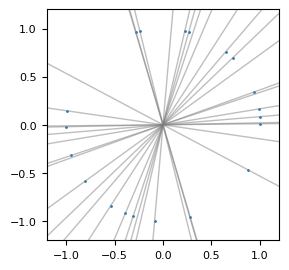

In [161]:
X_uh.plot_hd()

In [162]:
i = torch.randint(X_uni.shape[0],(1,)).item()
x = X_uni[i]

In [163]:
i

38694

In [164]:
X_uh.hashed[i], X_uh1.hashed[i]

(tensor([ 9., -8., -7.,  8.,  2., -6., -9., -1., -4.,  2., -6., -1.,  9.,  3., -1., -9., -2.,  8.,  6.,  5.]),
 tensor([ 4., -2., 11., -1., -5.]))

In [165]:
vc2, ref_nns2 = X_uh2.find_nns(X_uh1.hashed[i],2)
vc1, ref_nns1 = X_uh1.find_nns(X_uh.hashed[i],3, idx=ref_nns2)
vc0, ref_nns0 = X_uh.find_nns(X_uni[i],17, idx=ref_nns1)
vc, ref_nns = X_uh.find_nns(X_uni[i],17)

In [166]:
%%timeit -n 10
vc2, ref_nns2 = X_uh2.find_nns(X_uh1.hashed[i],2)
vc1, ref_nns1 = X_uh1.find_nns(X_uh.hashed[i],3, idx=ref_nns2)
vc0, ref_nns0 = X_uh.find_nns(X_uni[i],17, idx=ref_nns1)

The slowest run took 5.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1.49 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [167]:
%timeit -n 10 vc, ref_nns = X_uh.find_nns(X_uni[i],17)

3.71 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
ref_nns[(torch.isin(ref_nns, ref_nns0)==0).nonzero().squeeze()]

tensor([  343,   628,   843,  2262,  2458,  2691,  4309,  5589, 24026, 26291, 26390, 27475, 34247, 37808, 38554, 39649, 41029, 51914, 61400,
        62048, 67653, 77879, 85205, 89412, 92280, 92576, 92846, 94350, 96633, 96901])

In [169]:
vc.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [170]:
def plot_nns(pt, nns, X, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(8,6))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2, color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.3, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
    ax.set_xlim(-1170, -980)
    ax.set_ylim(-530, -350);

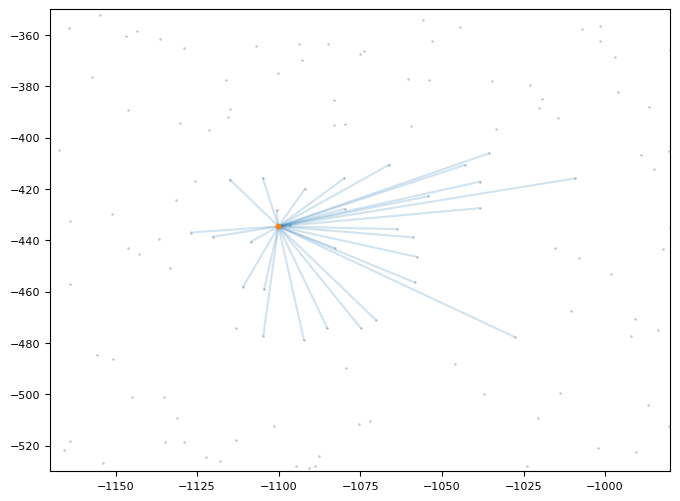

In [126]:
plot_nns(X_uni[i], ref_nns0, X_uni)

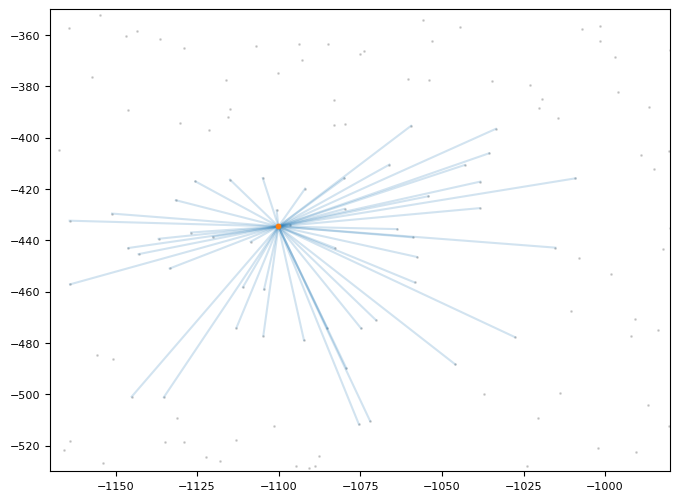

In [127]:
plot_nns(X_uni[i], ref_nns, X_uni)

The nn is faster when pre-selecting the areas with successive (1.57ms vs 3.31ms for `1e5` points) hashing but the cuts can sometimes remove a part of the neigbors. The right scale factors and number of collisions at each step is critical to lower the search time but keep the NN search qualitative. A method to adjust these parameters is necessary.<br>
We note that this exploration in 2D allows to vizualize things quickly but these hashing methods are much more powerful for high dimentional data. In the present case, a simple distance calculation + cutoff would be more straight forward and likely quicker.

#### Compare with a simple distance-cutoff

In [171]:
x = X_uni[i]
eps = 40

In [174]:
%%timeit -n 10
dists = torch.sqrt(((x-X_uni)**2).sum(1))
nns = torch.where(dists<eps)

The slowest run took 5.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1.03 ms ± 797 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is quicker and gives an exact result in 2D. However, if we stored the buckets in memory as we hashed the ensemble, it should be much faster to retrieve the ANNs especially for large numbers of points (but the preprocess of saving the buckets is very long):

In [175]:
%time X_test = Data_hash(X_uni,X_uni.shape[1], n_hash=20, scale_factor=0.005, store_hash=True, n_matches=17)

CPU times: user 5min 57s, sys: 3.43 s, total: 6min
Wall time: 1min 30s


In [177]:
%timeit -n 10 vc, ref_nns = X_test.find_nns(X_uni[i],17)

The slowest run took 14.13 times longer than the fastest. This could mean that an intermediate result is being cached.
91.9 µs ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1778]:
dists = torch.sqrt(((x-X_uni)**2).sum(1))
nns = torch.where(dists<eps)

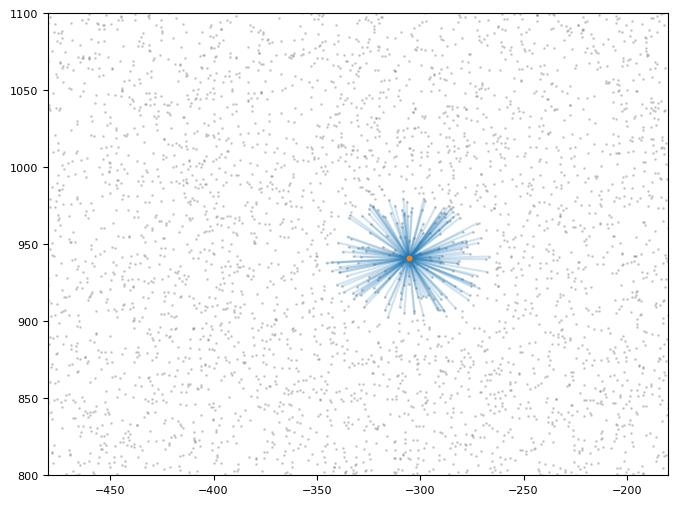

In [1779]:
plot_nns(x,nns,X_uni)

#### Compare with a dot product method

In [1910]:
x = X_uni[i]

In [1911]:
def normalize(x,X):
    Xt = torch.cat((x[None,:],X))
    Xmin, Xmax = Xt.min(), Xt.max()
    Xt_norm = 2*(Xt-Xmin)/(Xmax-Xmin) - 1
    return Xt_norm[0], Xt_norm[1:]

In [1912]:
def sim_vect(x, X, quick=False, f=None):
    xn, Xn = normalize(x,X)
    dot_mat = xn @ Xn.transpose(0,1)
    xn_norm, Xn_norm = torch.sqrt((xn**2).sum()), torch.sqrt((Xn**2).sum(1))
    norm_mat = xn_norm * Xn_norm
    if quick: mag_mat = torch.exp(-abs(xn_norm - Xn_norm)*f)
    else: mag_mat = torch.exp(-torch.sqrt(((xn - Xn)**2).sum(1)))
    sim_vec = dot_mat/norm_mat*mag_mat 
    return sim_vec

In [1913]:
def nn_search(sim_mat, e_sim):
    sim_bool = sim_mat>e_sim
    return sim_bool.nonzero().squeeze()

In [1914]:
%%timeit -n 10 
s_m = sim_vect(x,X_uni)
nn_l = nn_search(s_m,0.98)

25 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1915]:
s_m = sim_vect(x,X_uni)
nn_l = nn_search(s_m,0.98)

In [1916]:
s_m.unique()

tensor([-0.669, -0.669, -0.667,  ...,  0.999,  1.000,  1.000])

In [1917]:
nn_l

tensor([  2537,   3079,   5783,  10436,  10922,  13477,  15893,  26836,  30198,  40025,  43641,  44371,  45236,  47753,  51841,  52090,
         56134,  58581,  59728,  61381,  64347,  64997,  65112,  67907,  68436,  68499,  68704,  70639,  70804,  75063,  76857,  78676,
         80417,  84115,  84661,  87383,  95136,  97650,  98711, 103330, 108324, 109276, 118035, 121564, 127103, 129177, 129755, 132157,
        134674, 139419, 140422, 142201, 142909, 145297, 145332, 152295, 153619, 157066, 164477, 167339, 175102, 179263, 184182, 184628,
        184934, 188512, 190683, 192352, 193160, 199088, 206206, 209527, 210275, 211151, 211754, 223569, 235044, 236800, 237976, 238922,
        242695, 249430, 250268, 253350, 256864, 258975, 261886, 264417, 265220, 267618, 273160, 273899, 281807, 282816, 284807, 286088,
        292884, 297835, 297989, 298236, 298974, 304004, 306858, 310225, 320305, 326353, 326864, 330994, 335535, 339173, 340964, 343657,
        347620, 356649, 357026, 358748, 366824, 

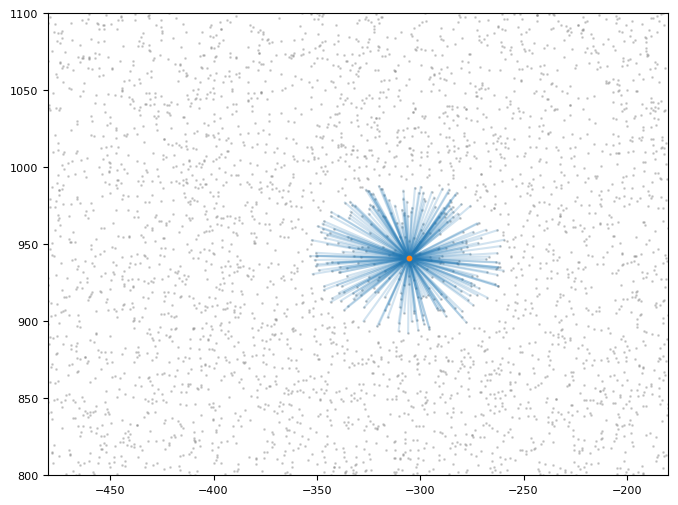

In [1891]:
plot_nns(x, nn_l, X_uni)

In [1905]:
%%timeit -n 10 
s_m = sim_vect(x, X_uni, quick=True, f=0.1)
nn_l = nn_search(s_m,0.995)

16 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1908]:
s_m = sim_vect(x,X_uni, quick=True, f=0.1)
nn_l = nn_search(s_m,0.999)

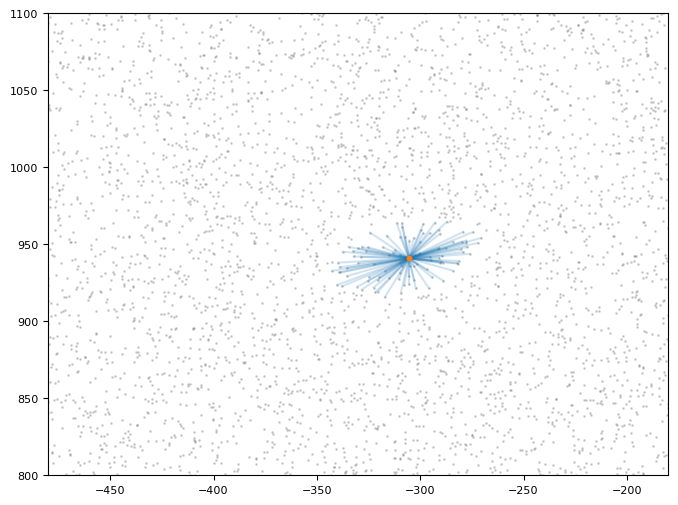

In [1909]:
plot_nns(x, nn_l, X_uni)